## NOTE: 
### To run this code, your Jupyter-notebook must be using Python3.8 or newer releases

# Prerequisites for calculation

Before I begin solving the tasks presented in the exercises I will define a set of constants to be used throughout this document. The meaning of the individual constants are briefly described in the appropriate comments.

In [1]:
import numpy as np

k_b = 1.38e-23                  #The boltzmann constant
T = 293                         #Example temperature (in Kelvin)
beta = 1 / (k_b * T)            #The inverse-temperature-constant for the example-temp

box_k = 600*k_b*T               #Spring-constant for box-walls

hardcore_diameter = 0.05        #Particle-diameter for hardcore interaction
hardcore_pot = 100000*k_b*T       #Particle-potential for hardcore interaction

N = 1000                        #Example amount of particles

epsilon = 1                     #Lennard-jones potential-constant
a = 0.1                         #Lennard-jones distance-constant


# Abstract box-system definitions
In order to quickly switch between using various inter-particle-potentials along with box-potentials for the particles in the $L\times L$ box, I will define a stateFunctions-class. Instances of this class will contain information about the potentials to be used, along with appropriate functions-definitions of these.  
  
This section is split into two code-boxes, where the first one was written as the .pyi file corresponding to the second one. The first code-block gives an overview of all functions defined in the second one, but is strictly speaking not neccesary.  
  
In this section I implement functions that calculate the energy and pressure for a given microstate. Each particle that lies outside the box would classically be influenced as if it were in a spring-system with spring-constant $k=box_k$. In a single dimension, the pressure-contribution from a single particle a distance $d$ outside the box would be calculated as $k\cdot d / A$, where $A$ is some relevant area. In our scenario, it is not neccesarily easy to define how the pressure should be calculated, especially outside the box-corners. I have chosen to sum up pressure-contribution from the x-direction and y-direction as if they were independent, and chosen $A=4\cdot L$, the one-dimensional area of the box. This allows calculating some pressure for a given microstate (though in reality pressure is a macroscopic quantity).  
  
Furthermore, the following section implements a series of energy-methods. The inter-particle energy-methods are Lennard-Jones, Hardcore, and No-interaction, all of which are coupled with the box-spring-system-energy as defined in the exercise-text. The energy-methods take in a system-state (a set of particle-positions) and yield a floating-point energy-value.  
  
All methods are compiled with jit to allow for fast execution.

In [2]:
from typing import Callable
import numpy as np
from enum import Enum


class ENERGY(Enum):
    BOX_ENERGY              :int = 1
    HARDCORE_AND_BOX_ENERGY :int = 2
    LJ_AND_BOX_ENERGY       :int = 3


class stateFunctions:
    box_k: float

    pressure: Callable[[np.ndarray, float], float]
    hardcore_energy: Callable[[np.ndarray, float], float]
    box_energy: Callable[[np.ndarray, float], float]
    box_and_hardcore_energy: Callable[[np.ndarray, float], float]
    box_and_lj_energy: Callable[[np.ndarray, float], float]
    single_particle_pressure: Callable[[np.ndarray, float, int], float]
    single_particle_box_energy: Callable[[np.ndarray, float, int], float]
    single_particle_hardcore_energy: Callable[[np.ndarray, float, int], float]
    single_particle_box_and_hardcore_energy: Callable[[np.ndarray, float, int], float]
    single_particle_box_and_lj_energy: Callable[[np.ndarray, float, int], float]

    def __init__(self, L: float, box_k: float, **kwargs):
        """
        Creates state-functions object with parameter L and box_k
        :param L: float
        :param box_k: float
        """
        ...

    def compile(self):
        """
        Recompile the energy- and pressure- methods of stateFunctions
        :return: None
        """
        ...

    def set_energy_type(self, energy_type: ENERGY):
        ...

    def get_energy(self) -> Callable[[np.ndarray, float], float]:
        ...

    def get_single_particle_energy(self) -> Callable[[np.ndarray, float, int], float]:
        ...

    def get_pressure(self) -> Callable[[np.ndarray, float], float]:
        ...

    def get_single_particle_pressure(self) -> Callable[[np.ndarray, float, int], float]:
        ...


In [3]:
from __future__ import annotations
from typing import List, Tuple, Callable, Dict, NamedTuple
import numpy as np
from numba import njit
from enum import Enum


class ENERGY(Enum):
    BOX_ENERGY              :int = 1
    HARDCORE_AND_BOX_ENERGY :int = 2
    LJ_AND_BOX_ENERGY       :int = 3


class stateFunctions:
    box_k: float

    pressure: Callable[[np.ndarray, float], float]
    hardcore_energy: Callable[[np.ndarray, float], float]
    box_energy: Callable[[np.ndarray, float], float]
    box_and_hardcore_energy: Callable[[np.ndarray, float], float]
    box_and_lj_energy: Callable[[np.ndarray, float], float]
    single_particle_pressure: Callable[[np.ndarray, float, int], float]
    single_particle_box_energy: Callable[[np.ndarray, float, int], float]
    single_particle_hardcore_energy: Callable[[np.ndarray, float, int], float]
    single_particle_box_and_hardcore_energy: Callable[[np.ndarray, float, int], float]
    single_particle_box_and_lj_energy: Callable[[np.ndarray, float, int], float]

    def __init__(self, box_k: float, **kwargs):
        self.box_k = box_k
        self.compile()
        self.energy_type = kwargs.get("energy_type", ENERGY.HARDCORE_AND_BOX_ENERGY)

    def set_energy_type(self, energy_type: ENERGY):
        self.energy_type = energy_type

    def get_energy(self) -> Callable[[np.ndarray], float]:
        return {ENERGY.BOX_ENERGY: self.box_energy,
                ENERGY.HARDCORE_AND_BOX_ENERGY: self.box_and_hardcore_energy,
                ENERGY.LJ_AND_BOX_ENERGY: self.box_and_lj_energy}[self.energy_type]

    def get_pressure(self) -> Callable[[np.ndarray], float]:
        return self.pressure

    def get_single_particle_energy(self) -> Callable[[np.ndarray, int], float]:
        return {ENERGY.BOX_ENERGY: self.single_particle_box_energy,
                ENERGY.HARDCORE_AND_BOX_ENERGY: self.single_particle_box_and_hardcore_energy,
                ENERGY.LJ_AND_BOX_ENERGY: self.single_particle_box_and_lj_energy}[self.energy_type]

    def get_single_particle_pressure(self) -> Callable[[np.ndarray, int], float]:
        return self.single_particle_pressure

    def compile(self):
        box_k = self.box_k

        @njit()
        def pressure(state: np.ndarray, L: float) -> float:
            pressure_contrib = np.sum(np.where(state < 0, -state, 0)) + \
                               np.sum(np.where(state > L, state - L, 0))
            pressure_contrib *= box_k / L / 4
            return pressure_contrib

        @njit()
        def single_particle_pressure(state:np.ndarray, L: float, i: int):
            return pressure(state[i], L)

        @njit()
        def hardcore_energy(state: np.ndarray, L: float) -> float:
            particle_amt = len(state)
            energy_contrib = 0.0
            for i in range(particle_amt):
                for j in range(i+1, particle_amt):
                    energy_contrib += hardcore_pot if np.linalg.norm(state[i] - state[j]) < hardcore_diameter else 0
            return energy_contrib

        @njit()
        def LJ_energy(state: np.ndarray, L: float) -> float:
            particle_amt = len(state)
            energy_contrib = 0.0
            for i in range(particle_amt):
                for j in range(i+1, particle_amt):
                    r = np.linalg.norm(state[i]-state[j])
                    energy_contrib += epsilon*((a/r)**12 - 2*(a/r)**6)
            return energy_contrib

        @njit()
        def single_particle_LJ_energy(state: np.ndarray, L: float, i: int) -> float:
            energy_contrib = 0.0
            particle_i = state[i]
            for j in range(len(state)):
                if j != i:
                    r = np.linalg.norm(particle_i - state[j])
                    energy_contrib += epsilon*((a/r)**12 - 2*(a/r)**6)
            return energy_contrib

        @njit()
        def single_particle_hardcore_energy(state: np.ndarray, L: float, i: int) -> float:
            energy_contrib = 0.0
            particle_i = state[i]
            for j in range(len(state)):
                if j != i:
                    energy_contrib += hardcore_pot if np.linalg.norm(particle_i - state[j]) < hardcore_diameter else 0
            return energy_contrib

        @njit()
        def box_energy(state: np.ndarray, L: float) -> float:
            energy_contrib: float = 1 / 2 * box_k * np.sum(np.where(state < 0, state ** 2, 0)) \
                                    + 1 / 2 * box_k * np.sum(np.where(state > L, (state - L) ** 2, 0))
            return energy_contrib

        @njit()
        def single_particle_box_energy(state: np.ndarray, L: float, i: int) -> float:
            return box_energy(state[i], L)

        @njit()
        def box_and_hardcore_energy(state: np.ndarray, L: float) -> float:
            return box_energy(state, L) + hardcore_energy(state, L)

        @njit()
        def single_particle_box_and_hardcore_energy(state: np.ndarray, L: float, i: int) -> float:
            return single_particle_box_energy(state, L, i) + single_particle_hardcore_energy(state, L, i)

        @njit()
        def box_and_LJ_energy(state: np.ndarray, L: float):
            return box_energy(state, L) + LJ_energy(state, L)

        @njit()
        def single_particle_box_and_LJ_energy(state: np.ndarray, L: float, i: int):
            return single_particle_box_energy(state, L, i) + single_particle_LJ_energy(state, L, i)

        self.pressure = pressure
        self.hardcore_energy = hardcore_energy
        self.box_energy = box_energy
        self.box_and_hardcore_energy = box_and_hardcore_energy
        self.box_and_lj_energy = box_and_LJ_energy
        self.single_particle_pressure = single_particle_pressure
        self.single_particle_box_energy = single_particle_box_energy
        self.single_particle_hardcore_energy = single_particle_hardcore_energy
        self.single_particle_box_and_hardcore_energy = single_particle_box_and_hardcore_energy
        self.single_particle_box_and_lj_energy = single_particle_box_and_LJ_energy






Now I will define the actual systems used in simulations. These 'systems' consist of a state, describing the positions of all its particles, along with a series of parameters specifying the behaviour of the system. One such parameter is the 'state-functions'-object the system will use to calculate energies for a given state. Furthermore, the system has a function named 'explore' which will propagate the system-state with the metropolis Monte-Carlo method in accordance with its parameters. Like before, I have split the definitions into a descriptive '.pyi'-code-block, and another code block that actually implements all the methods. 

In [4]:
class System:
    state: np.ndarray
    particle_amt: int
    dimension: int
    L: float
    jump_scale: float

    pressure: Callable[[np.ndarray], float]
    energy: Callable[[np.ndarray], float]

    def __init__(self, particle_amt: int, L: float, state_functions: stateFunctions, **kwargs): ...

    def reset(self, L: float=None, recompile: bool=False):
        ...

    def explore(self, iterations: int, log_interval: int = 1):
        """
        Jitted method of performing multiple goto_next-steps, moving a single, randomly selected
        particle at a time
        :param iterations: int; iterations to perform
        :return:
        """
        ...

In [5]:
import numpy as np
from numba import njit
from typing import List, Tuple, Callable, Dict


class System:
    state: np.ndarray
    particle_amt: int
    dimension: int
    L: float
    jump_scale: float

    pressure: Callable[[np.ndarray, float], float]
    energy: Callable[[np.ndarray, float], float]

    def __init__(self, particle_amt: int, L: float, state_functions: stateFunctions, temperature: float = T, **kwargs):
        self.particle_amt = particle_amt
        self.positional_dimension = 2           # 2D system
        self.dimension = self.particle_amt*self.positional_dimension
        self.L = L
        self.state_functions = state_functions
        self.jump_scale = kwargs.get("jump_scale", 1)
        self.T = temperature

        self.logEnergy = kwargs.get("logEnergy", True)
        self.logPressure = kwargs.get("logPressure", True)

        self.compile()

        # Generating initial random state
        self.reset()

    def reset(self, L: float=None, recompile: bool=False):
        if L is not None:
            self.L = L
        self.state = np.random.random((self.particle_amt, self.positional_dimension)) * self.L
        if recompile:
            self.compile()

    def compile(self):
        jump_scale = self.jump_scale
        energy = self.state_functions.get_energy()
        pressure = self.state_functions.get_pressure()
        single_energy = self.state_functions.get_single_particle_energy()
        single_pressure = self.state_functions.get_single_particle_pressure()
        T = self.T
        pos_dim = self.positional_dimension
        logEnergy = self.logEnergy
        logPressure = self.logPressure
        @njit()
        def jitted_explore(initial_state: np.ndarray, L: float, iterations: int, log_interval=100) -> Tuple[np.ndarray, List[List[float]]]:
            beta = 1.0 / (k_b * T)

            def particle_choice(state):
                i = np.random.randint(0, len(state))
                return i

            def jump():
                stepped_length = np.random.uniform(-jump_scale, jump_scale, (pos_dim,))
                return stepped_length

            def goto_next(state, i):
                single_step = jump()
                current_energy = single_energy(state, L, i)
                position_i_current = state[i] + 0
                state[i] += single_step
                next_energy = single_energy(state, L, i)
                delta_energy = next_energy - current_energy
                if not (delta_energy < 0 or np.random.random() < np.exp(-beta * delta_energy)) :
                    state[i] = position_i_current
                return state

            pressures = [0.0][:0]
            energies = [0.0][:0]

            state = initial_state
            for iter in range(iterations):
                i = particle_choice(state)
                state = goto_next(state, i)
                if iter % log_interval == 0:
                    if logPressure: pressures.append(pressure(state, L))
                    if logEnergy: energies.append(energy(state, L))
            return state, [pressures, energies]
        self._explore = jitted_explore

    def __len__(self):
        return self.particle_amt

    def __getitem__(self, index: int):
        return self.state[index]

    def explore(self, iterations: int, log_interval: int = 1):
        state, values = self._explore(self.state, self.L, iterations, log_interval)
        self.state = state
        return dict(zip(["pressure", "energy"], values))


All the exercises may now be solved in a short and concise way. 
  
### Task a)
For no particular reason I have chosen box-lengths $L$ in the interval $[0.1\text{m}, 10\text{m}]$ for testing the validity of the Ideal-Gas Law in an $L\times L$ box with the Metropolis Monte Carlo method.  
  
The jump-scale variable (briefly mentioned in the exercise-text, although it differs from the one defined in code by a factor 2) is here set to $0.08$, meaning that a particle may be moved at most $0.08\text{m}$ during Metropolis-Monte-Carlo iteration. There is no particular reason for choosing $0.08\text{m}$, other than that it seems to allow for fairly fast propagation of the particles, at the same time as it doen't reject too many proposed steps (as the particles rarely end up far outside the box, where the Monte-Carlo method most definitely would reject propagation and the state would remain unchanged). Choosing step-length $0.08\text{m}$ generates a fair amount of different microstates.  
  
Before I actually begin calculating pressures in the Monte-Carlo method, I will perform $500000$ iterations to allow the system to 'stabilize' (stabilize in a macroscopic sense). The system initiates by spreading the particles uniformly in the $L\times L$ box, but one needs to allow a few particles to venture outside the box before one begins calculating pressures and energies. Otherwise, these values would likely be unrepresentatively low.

^^^^^^^^^^^^^^^^^^^^
********************

<ipython-input-6-84c41da6450f>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


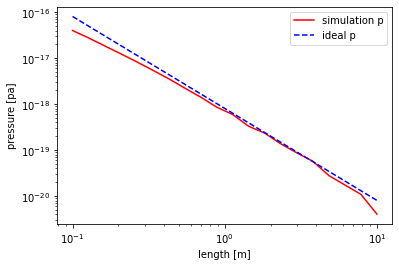

In [6]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.lines import Line2D

lower_l_lim = -1     #10^-1 = min_l
upper_l_lim = 1      #10^1 = max_l

lengths_amount = 20

particle_amt = 200

stabilization_iterations = 10000  #Iterations used for allowing the system to stabilize
averaging_iterations = 100000      #Iterations used for calculating an average

fig, ax = plt.subplots(1,1)
lengths = np.logspace(lower_l_lim, upper_l_lim, lengths_amount)
pressures = []
print("^"*lengths_amount)
state_fcns = stateFunctions(box_k, energy_type = ENERGY.BOX_ENERGY)
sys = System(particle_amt, 1, state_fcns, jump_scale = 0.05, logEnergy=False)
for length in lengths:
    sys.reset(L=length)
    sys.explore(stabilization_iterations, log_interval=1000)
    
    pressure_values = sys.explore(averaging_iterations, log_interval=100)["pressure"] #Pressure is only logged every 1000 iterations 
                                                        #as it is unneccesary to calculate pressures for similar microstates
    average_pressure = np.average(pressure_values)
    pressures.append(average_pressure)
    print("*", end="")
ax.plot(lengths, pressures, label="simulation p", color="r")
ideal_pressures = particle_amt * k_b * T / (lengths**2)

ax.plot(lengths, ideal_pressures, label= "ideal p", color = "b", linestyle="--")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("length [m]")
ax.set_ylabel("pressure [pa]")

fig.show()

There seems to be good correspondence between our calculations and the ideal-gas-law. In order to demonstrate that the particles in fact move around (not as described by the laws of motion, but generating a set of microstates), I will construct a gif showing the particle-trails during the monte-carlo-iterations. In this case I will only render the simulation with $20$ particles, as including more would only clutter the plot.

MovieWriter ffmpeg unavailable; using Pillow instead.


*************************************************************************************************************************************************************************************************************************************************************************************************************
anim.gif may now be found in CWD


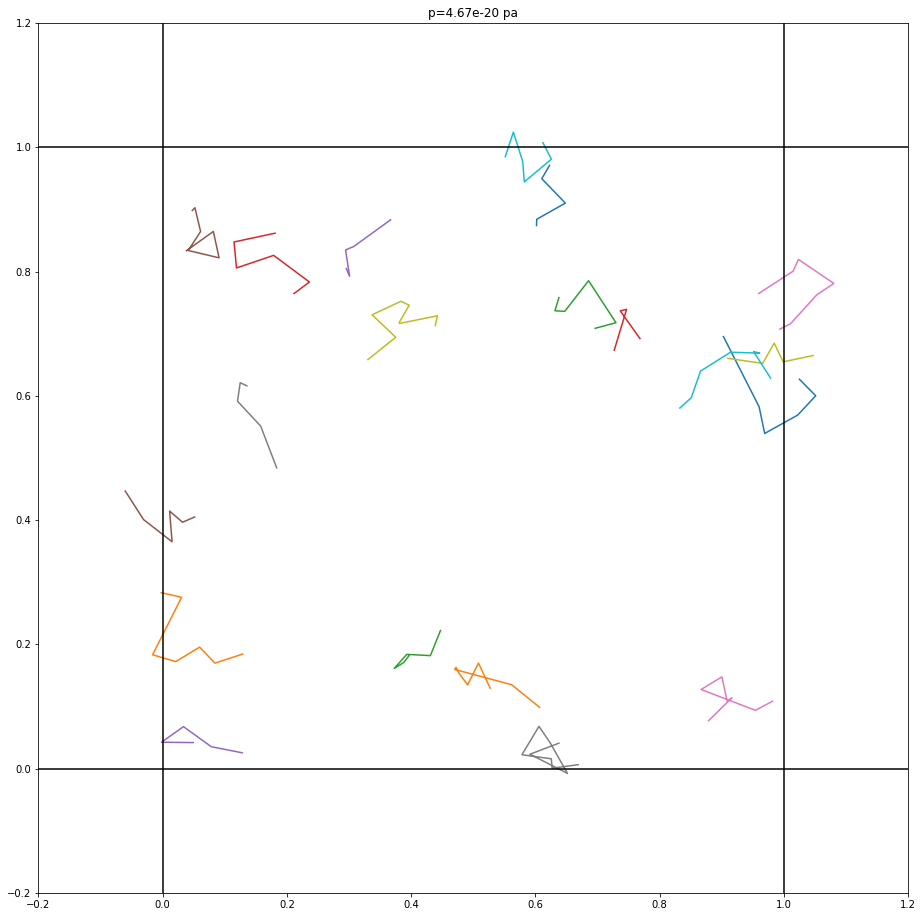

In [7]:
from matplotlib.animation import FuncAnimation
plot_amt = 20      #antall partikler

anim_iters = 20   #Iterasjoner mellom hvert plot
anim_frames = 300   #Antall frames

L = 1

if __name__ == "__main__":

    #Plotting a single system

    state_fcns = stateFunctions(box_k, energy_type=ENERGY.BOX_ENERGY)
    sys = System(plot_amt, L, state_fcns, jump_scale=0.05, logEnergy=False)
    fig, ax = plt.subplots(1,1, figsize=(16,16))
    data_storage = [elem for x_data, y_data in sys.state for elem in ([x_data], [y_data])]   #yeehaw
    curves:List[Line2D] = ax.plot(*data_storage)
    ax.set_aspect("equal")
    ax.set_xlim([-0.2, 1.2])
    ax.set_ylim([-0.2, 1.2])
    ax.axvline(1, color="k"); ax.axvline(0, color="k")
    ax.axhline(0, color="k"), ax.axhline(1, color="k")


    def animate(*args):
        pressure = sys.explore(anim_iters, log_interval=anim_iters)["pressure"]
        print("*", end="")
        ax.set_title(f"p={pressure[0]:.3g} pa")
        for enum, (x_data, y_data) in enumerate(sys.state):
            data_storage[2*enum].append(x_data)
            data_storage[2*enum+1].append(y_data)
            data_storage[2*enum] = data_storage[2*enum][-10:]
            data_storage[2*enum+1] = data_storage[2*enum+1][-10:]
        for enum, line in enumerate(curves):
            line.set_data((data_storage[2*enum], data_storage[2*enum + 1]))
        return curves
    anim = FuncAnimation(fig, animate, anim_frames)
    anim.save("anim.gif", fps=30)
    print("")
    print("anim.gif may now be found in CWD")
    del fig, ax, anim
    


In [8]:
from IPython.display import Image
Image(url="anim.gif")

It is evident that the particles move around sufficiently to generate several microstates.

## Task b)
The methods used here are largely the same as in $\textbf{(a)}$

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
******************************

<ipython-input-9-9dd123400a26>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


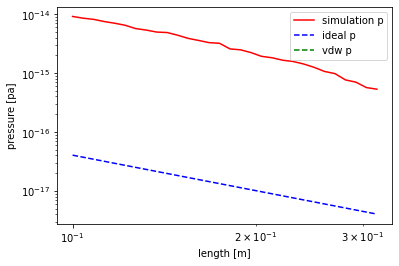

In [9]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.lines import Line2D

particle_amt = 100

stabilization_iterations = 5000  #Iterations used for allowing the system to stabilize
averaging_iterations = 100000      #Iterations used for calculating an average
lengths_amount = 30
upper_l_lim = -0.5

fig, ax = plt.subplots(1,1)
lengths = np.logspace(lower_l_lim, upper_l_lim, lengths_amount)
pressures = []
print("^"*lengths_amount)
box_k = 100000*k_b*T
state_fcns = stateFunctions(box_k, energy_type = ENERGY.HARDCORE_AND_BOX_ENERGY)
sys = System(particle_amt, 1, state_fcns, jump_scale = 0.05, logEnergy=False)
for length in lengths:
    sys.reset(L=length)
    sys.explore(stabilization_iterations, log_interval=1000)
    
    pressure_values = sys.explore(averaging_iterations, log_interval=3)["pressure"] #Pressure is only logged every 3 iterations 
                                                        #as it is unneccesary to calculate pressures for similar microstates
    average_pressure = np.average(pressure_values)
    pressures.append(average_pressure)
    print("*", end="")
ax.plot(lengths, pressures, label="simulation p", color="r")
vdw_pressures = particle_amt * k_b * T / (lengths**2-np.pi*hardcore_diameter**2/2*particle_amt)
ideal_pressures = particle_amt * k_b * T / (lengths**2)

ax.plot(lengths, ideal_pressures, label= "ideal p", color = "b", linestyle="--")
ax.plot(lengths, vdw_pressures, label="vdw p", color="g", linestyle="--")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("length [m]")
ax.set_ylabel("pressure [pa]")

fig.show()

As length of the box decreases, the simulation-pressure seems to approximate the calculated Van-Der-Walls pressure far better than the ideal-gas pressure, but this does not hold when the box-volumes approach the total volume of each particle. In this case, the simulation likely returns a somewhat low pressure due to the finite box-constant. In an 'ideal' box, this constant would be infinite, and the particles would never be able to leave the box. This would however be infeasible for calculating pressures excerted by the particles on the box, as our pressure-calculation only consider the particles that have left the box.
  
  
  For finite box-contants, particles could remain outside the box and still produce a finite pressure, overfilling the box. This would effectively allow the particles to occupy a volume larger than that of the box, lowering the calculated pressure from what it 'ideally' should have been. 

## Task c)


T=2.90e+22K:----------

<ipython-input-10-a11488c02bd9>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


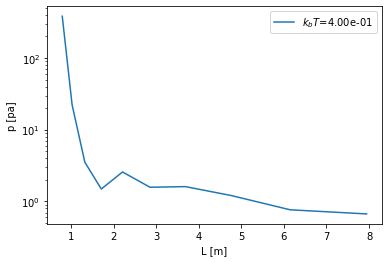

In [10]:
#Temps = np.array([0.4, 0.55, 2.0])/k_b
Temps = np.array([0.4])/k_b
particle_amt = 100
Ls = np.logspace(-0.1,0.9,10)

stabilization_iters = 20000
averaging_iters = 800000
box_k = 1000

fig, ax = plt.subplots(1,1)



state_fcns = stateFunctions(box_k, energy_type=ENERGY.LJ_AND_BOX_ENERGY)
for T in Temps:
    sys = System(particle_amt, 1, state_fcns, T, logEnergy=False, jump_scale=0.05)
    print(f"\nT={T:.2e}K", end=":")
    pressures = []
    for L in Ls:
        sys.reset(L=L)
        sys.explore(stabilization_iters, log_interval=1000)
        computed_pressures = sys.explore(averaging_iters, log_interval=5)["pressure"]
        avg_pressure = np.average(computed_pressures)
        pressures.append(avg_pressure)
        print("-",end="")
    ax.plot(Ls, pressures, label=fr"$k_bT$={k_b*T:.2e}")
ax.legend()
ax.set_xlabel("L [m]")
ax.set_ylabel("p [pa]")
ax.set_yscale("log")
fig.show()

Like the hardcore-potential case, the Lennard-Jones calculations yield a pressure-area graph where the pressure suddenly leaps for sufficiently small box-lengths. Both potentials encompass some sort of high potential for particles sufficiently near each other. It is this effect that causes this sudden jump in pressure for small volumes, which somewhat corresponds to the particles forming a solid phase (with a fixed lattice-distance).  
  
As the volume gets big enough, the pressure-graphs behave somewhat similarly to the ideal-gas-graphs, corresponding to the systems aquiring a gaseous phase.  
  
  
Unlike the pressure-volume-graphs calculated before, this graph encompasses some 'almost flat' region. This corresponds to regions where the particles form a mixed-phase system, where small changes to volume only affect the proportionality of each phase, but not the overall pressure. This is most evident in the graph corresponding to the lowest temperature. The reason for the spiky-ness is likely that the simulations were not long enough. It has been experienced that 'crystal flakes' could form on the boundary of my box-simulations, flakes which generally are not stable, but my simulations were not long enough for them to migrate into the box. Thus, small differences in starting-position of the particles could make up significant pressure-differences in the calculations.

## Task d)


T=2.88e+22K:
T=3.29e+22K:
T=3.75e+22K:
T=4.28e+22K:
T=4.88e+22K:
T=5.57e+22K:
T=6.35e+22K:
T=7.25e+22K:
T=8.27e+22K:
T=9.43e+22K:
T=1.08e+23K:
T=1.23e+23K:
T=1.40e+23K:
T=1.60e+23K:
T=1.82e+23K:

<ipython-input-11-cfbf5258ef11>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


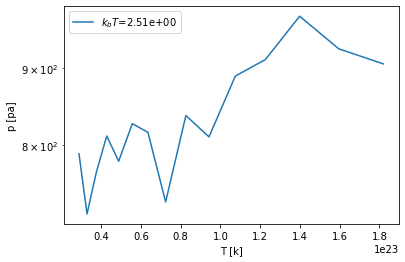

In [11]:
Temps = np.array([0.4, 0.9, 2.4])/k_b
particle_amt = 200
L = 1.6

stabilization_iters = 1000
averaging_iters = 20000
box_k = 300

fig, ax = plt.subplots(1,1)



state_fcns = stateFunctions(box_k, energy_type=ENERGY.LJ_AND_BOX_ENERGY)
pressures = []
Temps = np.logspace(-0.4,0.4,15)/k_b
for T in Temps:
    sys = System(particle_amt, 1, state_fcns, T, logEnergy=False, jump_scale=0.2)
    print(f"\nT={T:.2e}K", end=":")
    sys.explore(stabilization_iters, log_interval=1000)
    computed_pressures = sys.explore(averaging_iters, log_interval=10)["pressure"]
    avg_pressure = np.average(computed_pressures)
    pressures.append(avg_pressure)
ax.plot(Temps, pressures, label=fr"$k_bT$={k_b*T:.2e}")
ax.legend()
ax.set_xlabel("T [k]")
ax.set_ylabel("p [pa]")
ax.set_yscale("log")
fig.show()